In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/Mgdec/'

import sys
sys.path.append(basepath+'note/')

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

from lowda import load_galaxy
import lowda as lwd
from scipy.spatial import KDTree

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [4]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [57]:
def partTypeNum(partType):
    """ Mapping between common names and numeric particle types. """
    if str(partType).isdigit():
        return int(partType)
        
    if str(partType).lower() in ['gas','cells']:
        return 0
    if str(partType).lower() in ['dm','darkmatter']:
        return 1
    if str(partType).lower() in ['dmlowres']:
        return 2 # only zoom simulations, not present in full periodic boxes
    if str(partType).lower() in ['tracer','tracers','tracermc','trmc']:
        return 3
    if str(partType).lower() in ['star','stars','stellar']:
        return 4 # only those with GFM_StellarFormationTime>0
    if str(partType).lower() in ['wind']:
        return 4 # only those with GFM_StellarFormationTime<0
    if str(partType).lower() in ['bh','bhs','blackhole','blackholes']:
        return 5
    
    raise Exception("Unknown particle type name.")

def maxPastMass(tree, index, partType='stars'):
    """ Get maximum past mass (of the given partType) along the main branch of a subhalo
        specified by index within this tree. """
    ptNum = partTypeNum(partType)

    branchSize = tree['MainLeafProgenitorID'][index] - tree['SubhaloID'][index] + 1
    masses = tree['SubhaloMassType'][index: index + branchSize, ptNum]
    return np.max(masses)

def numMergers(tree, treeMPB, minMassRatio=1e-10, massPartType='stars', index=0, alongFullTree=False):
    """ Calculate the number of mergers, along the main progenitor branch, in this sub-tree 
    (optionally above some mass ratio threshold). If alongFullTree, count across the full 
    sub-tree and not only along the MPB. """
    # verify the input sub-tree has the required fields
    reqFields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID',
                 'FirstProgenitorID', 'SubhaloMassType']

    if not set(reqFields).issubset(tree.keys()):
        raise Exception('Error: Input tree needs to have loaded fields: '+', '.join(reqFields))

    num = 0
    invMassRatio = 1.0 / minMassRatio

    # walk back main progenitor branch
    rootID = tree['SubhaloID'][index]
    fpID   = tree['FirstProgenitorID'][index]
    
    prevIndex = index

    while fpID != -1:
        fpIndex = index + (fpID - rootID)
        fpMass  = maxPastMass(tree, fpIndex, massPartType)

        # print('prev snap, fp snap:', tree['SnapNum'][prevIndex], tree['SnapNum'][fpIndex])
        
        # explore breadth
        npID = tree['NextProgenitorID'][fpIndex]

        while npID != -1:
            npIndex = index + (npID - rootID)
            npMass  = maxPastMass(tree, npIndex, massPartType)

            # count if both masses are non-zero, and ratio exceeds threshold
            if fpMass > 0.0 and npMass > 0.0:
                ratio = npMass / fpMass

                if ratio >= minMassRatio and ratio <= invMassRatio:
                    num += 1
                    print(tree['SnapNum'][fpIndex], tree['SnapNum'][npIndex], fpMass, npMass, ratio)
                    
                    # find MP at this snap
                    npsnap = tree['SnapNum'][npIndex]
                    subIDnp = tree['SubfindID'][npIndex]
                    subhaloNP = il.groupcat.loadSingle(TNGbase, npsnap, subhaloID=subIDnp)
                    IDmostbound = subhaloNP['SubhaloIDMostbound']
                    
                    snapNP = il.snapshot.loadSubhalo(TNGbase, npsnap, subIDnp, 1, 
                                                     fields=['Coordinates', 'ParticleIDs'])
                    
                    print(np.isin(IDmostbound, snapNP['ParticleIDs']))
                    
                    key = np.where(treeMPB['SnapNum'] == npsnap)[0][0]
                    subIDmp = treeMPB['SubfindID'][key]
                    subhaloMP = il.groupcat.loadSingle(TNGbase, npsnap, subhaloID=subIDmp)
                    
                    r = np.linalg.norm(subhaloNP['SubhaloPos'] - subhaloMP['SubhaloPos'])
                    print(r, IDmostbound)

            npID = tree['NextProgenitorID'][npIndex]

            # count along full tree instead of just along the MPB? (non-standard)
            if alongFullTree:
                if tree['FirstProgenitorID'][npIndex] != -1:
                    numSubtree = numMergers(tree, minMassRatio=minMassRatio, massPartType=massPartType, index=npIndex)
                    num += numSubtree

        fpID = tree['FirstProgenitorID'][fpIndex]
        prevIndex = fpIndex

    return num

In [58]:
subID_atsnap = 172175
snap = 40
treeMPB = il.sublink.loadTree(TNGbase, snap, subID_atsnap, onlyMPB=True)
tree = il.sublink.loadTree(TNGbase, snap, subID_atsnap)

In [59]:
numMergers(tree, treeMPB, minMassRatio=0.1)

12 11 0.011106764 0.0028435371 0.25601852
True
91.45672 7143353804
9 8 0.0022239117 0.00034909326 0.15697263
True
66.82731 7261471708
1 1 5.0460785e-05 5.767071e-06 0.11428817
True
26.228292 7348939980
1 1 5.0460785e-05 7.005916e-06 0.13883883
True
50.032654 7231860188


4

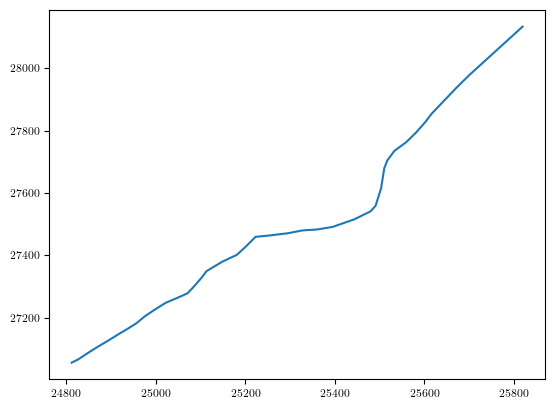

In [53]:
plt.plot(treeMPB['SubhaloPos'][:,0], treeMPB['SubhaloPos'][:,1])

In [63]:
ParticleID = 7143353804

ParticleTraj = np.full_like(treeMPB['SubhaloPos'], np.nan)
for i in tqdm(range(len(treeMPB['SubhaloGrNr']))):
    snapnum = treeMPB['SnapNum'][i]
    GrNr = treeMPB['SubhaloGrNr'][i]
    snap = il.snapshot.loadHalo(TNGbase, snapnum, GrNr, 1, fields=['Coordinates', 'ParticleIDs'])
    
    key = snap['ParticleIDs'] == ParticleID
    
    if np.sum(key) == 0:
        continue
    
    if np.sum(key) > 1:
        print('panic')
    
    ParticleTraj[i] = snap['Coordinates'][key]
    

100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


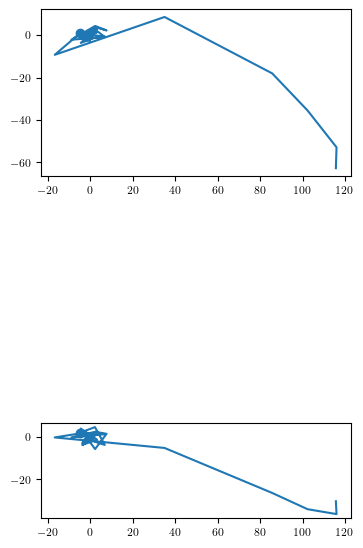

In [74]:
pos = ParticleTraj - treeMPB['SubhaloPos']

fig, axs = plt.subplots(2, 1, figsize=(4, 9))
axs[0].plot(pos[:,0], pos[:,2])
axs[1].plot(pos[:,0], pos[:,1])

for x in axs:
    x.set_aspect('equal')

k = treeMPB['SnapNum']==14
axs[0].scatter(pos[k,0], pos[k,2])
axs[1].scatter(pos[k,0], pos[k,1])

In [81]:
meta['time'][31]

2.9804158136757444

In [84]:
for k in treeMPB.keys():
    print(k)

count
DescendantID
FirstProgenitorID
FirstSubhaloInFOFGroupID
GroupBHMass
GroupBHMdot
GroupCM
GroupFirstSub
GroupGasMetalFractions
GroupGasMetallicity
GroupLen
GroupLenType
GroupMass
GroupMassType
GroupNsubs
GroupPos
GroupSFR
GroupStarMetalFractions
GroupStarMetallicity
GroupVel
GroupWindMass
Group_M_Crit200
Group_M_Crit500
Group_M_Mean200
Group_M_TopHat200
Group_R_Crit200
Group_R_Crit500
Group_R_Mean200
Group_R_TopHat200
LastProgenitorID
MainLeafProgenitorID
Mass
MassHistory
NextProgenitorID
NextSubhaloInFOFGroupID
NumParticles
RootDescendantID
SnapNum
SubfindID
SubhaloBHMass
SubhaloBHMdot
SubhaloCM
SubhaloGasMetalFractions
SubhaloGasMetalFractionsHalfRad
SubhaloGasMetalFractionsMaxRad
SubhaloGasMetalFractionsSfr
SubhaloGasMetalFractionsSfrWeighted
SubhaloGasMetallicity
SubhaloGasMetallicityHalfRad
SubhaloGasMetallicityMaxRad
SubhaloGasMetallicitySfr
SubhaloGasMetallicitySfrWeighted
SubhaloGrNr
SubhaloHalfmassRad
SubhaloHalfmassRadType
SubhaloID
SubhaloIDMostbound
SubhaloIDRaw
Subhalo

/tmp/ipykernel_854223/324025765.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, dydx/y)
/tmp/ipykernel_854223/324025765.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(x, dydx/y)


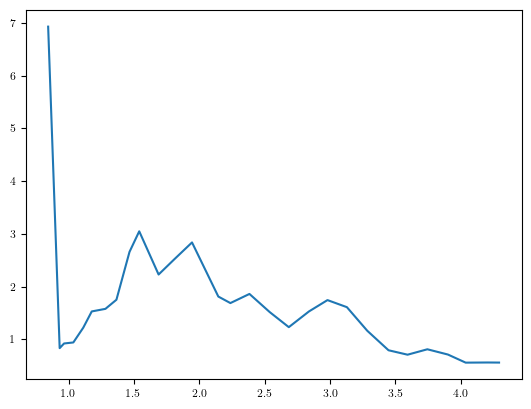

In [92]:
x = meta['time'][treeMPB['SnapNum']]
y = treeMPB['SubhaloBHMass']

dydx = np.gradient(y, x)

plt.plot(x, dydx/y)